In [1]:
import numpy as np
from sklearn.metrics.pairwise import *
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#データの生成
np.random.seed(0)
data1 = np.random.randn(100, 2)+np.array([2,4])
data2 = np.random.randn(100, 2)+np.array([4,2])
data = np.r_[data1, data2]
y = np.r_[np.ones(100), (-1)*np.ones(100)]

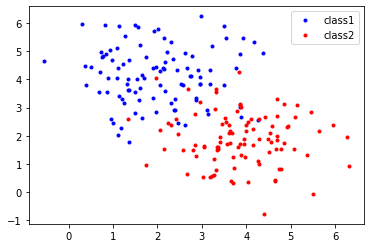

In [3]:
#データ分布の可視化
plt.figure()
plt.plot(data1[:,0], data1[:,1], 'b.', label="class1")
plt.plot(data2[:,0], data2[:,1], 'r.', label="class2")
plt.legend()
plt.show()
plt.close()

# 部分空間法

In [4]:
import numpy as np
from sklearn.metrics.pairwise import *


class SM(object):
    def __init__(self, eta=0.99, pos=None, kernel=None, gamma='auto'):
        self.eta_flag = True
        if pos is not None:
            self.eta_flag = False
            self.pos = pos

        self.kernel_flag = False
        if kernel is not None:
            self.kernel_flag = True
            self.kernel = kernel
            self.gamma = gamma
            """
            gammaのauto機能はsklearnに合わせる. ただしsklearnではscaleと同等
            gamma : float, optional (default='auto')
            Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.
            Current default is 'auto' which uses 1 / n_features,
            if ``gamma='scale'`` is passed then it uses 1 / (n_features * X.var())
            as value of gamma. The current default of gamma, 'auto', will change
            to 'scale' in version 0.22. 'auto_deprecated', a deprecated version of
            'auto' is used as a default indicating that no explicit value of gamma
            was passed.
            """

        self.eta = eta

    def _set_kernel(self, X, Y=None):
        if(self.kernel == 'rbf'):
            return rbf_kernel(X, Y, gamma=self.gamma)
        elif(self.kernel == 'poly'):
            return polynomial_kernel(X, Y, degree=self.d, gamma=1, coef0=1)
        else:
            return linear_kernel(X, Y)

    def _select_eig(self, e_val, e_vec):
        e_val, e_vec = e_val[::-1], e_vec.T[::-1].T
        if self.eta_flag is True:
            zero_idx = np.where(e_val > 0)
            e_val, e_vec = e_val[zero_idx], e_vec.T[zero_idx].T
            sum_all = np.sum(e_val)
            sum_value = np.array(
                [np.sum(e_val[:i])/sum_all for i in range(1, len(e_val)+1)])
            r = int(np.min(np.where(sum_value >= self.eta)[0])+1)
        else:
            r = self.pos
        return e_vec.T[:r].T, e_val[:r]

    def fit(self, train_X):
        self.train_X = train_X
        if self.kernel_flag is True:
            self._fit_kernel()
        else:
            self._fit_linear()

    def _fit_linear(self):
        G = self.train_X.T @ self.train_X/self.train_X.shape[0]
        e_val, e_vec = np.linalg.eigh(G)
        self.basis, _ = self._select_eig(e_val, e_vec)

    def _fit_kernel(self):
        if self.gamma == 'auto':
            self.gamma = 1/(self.train_X.shape[1]*self.train_X.var())
        K = self._set_kernel(self.train_X)
        e_val, e_vec = np.linalg.eigh(K/K.shape[0])
        self.basis, self.lamda = self._select_eig(e_val, e_vec)

    def score(self, X):
        self.X = X
        if self.kernel_flag is True:
            return self._score_kernel()
        else:
            return self._score_linear()

    def _score_linear(self):
        x_norm = np.linalg.norm(self.X, axis=1).reshape(-1, 1)
        return np.sum(1-(self.X@self.basis/x_norm)**2, axis=1)

    def _score_kernel(self):
        test_K = self._set_kernel(self.X, self.train_X)
        return np.sum(1-(test_K@self.basis)**2/(self.train_X.shape[0]*self.lamda.reshape(1, -1)), axis=1)

In [5]:
def svdd_set_sklearn_backgound(cls, x_r, y_r):
    N = 1000

    #color_map = LinearSegmentedColormap.from_list("color_map", [
    #        (0.0, "#f59322"),
    #        (0.5, "#ffffff"),
    #        (1.0, "#0877bd"),])
    color_map = 'coolwarm_r'
    
    X, Y = np.meshgrid(np.linspace(*x_r, N), np.linspace(*y_r, N))
    X = np.hstack(X)
    Y = np.hstack(Y)
    Z=np.dstack((X, Y)).reshape(-1, 2)
    Z = cls.score(Z).reshape(N,N)
    X = X.reshape((N, -1))
    Y = Y.reshape((N, -1))

    plt.pcolor(X, Y, Z, cmap=color_map)

## 線形

In [6]:
#学習
sm = SM(eta=0.99, pos=1, kernel=None, gamma='auto')
normal_idx = np.where(y==-1)
sm.fit(data[normal_idx])

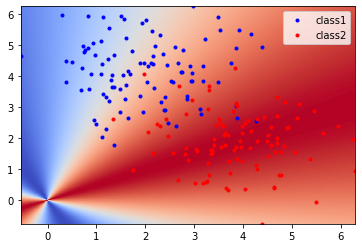

In [7]:
x_r = [min(data[:,0]), max(data[:,0])]
y_r = [min(data[:,1]), max(data[:,1])]
svdd_set_sklearn_backgound(sm, x_r, y_r)
plt.xlim(x_r)
plt.ylim(y_r)
t = np.linspace(start=min(data[:,0]), stop = max(data[:,0]), num=50)
plt.plot(data1[:,0], data1[:,1], 'b.', label="class1")
plt.plot(data2[:,0], data2[:,1], 'r.', label="class2")
plt.legend()
plt.show()
plt.close()

## 非線形

In [8]:
#学習
ksm = SM(eta=0.99, pos=None, kernel='rbf', gamma='auto')
normal_idx = np.where(y==-1)
ksm.fit(data[normal_idx])

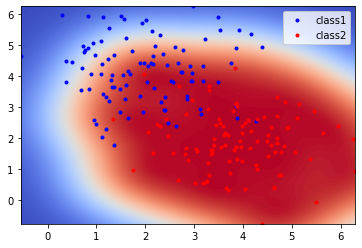

In [9]:
x_r = [min(data[:,0]), max(data[:,0])]
y_r = [min(data[:,1]), max(data[:,1])]
svdd_set_sklearn_backgound(ksm, x_r, y_r)
plt.xlim(x_r)
plt.ylim(y_r)
t = np.linspace(start=min(data[:,0]), stop = max(data[:,0]), num=50)
plt.plot(data1[:,0], data1[:,1], 'b.', label="class1")
plt.plot(data2[:,0], data2[:,1], 'r.', label="class2")
plt.legend()
plt.show()
plt.close()

# Improved SM (ISM)

In [10]:
import numpy as np
from sklearn.metrics.pairwise import *

class ISM(object):
    def __init__(self, C=0.01, eta=0.99, pos=None, kernel=None, gamma='auto'):
        self.eta_flag = True
        if pos is not None:
            self.eta_flag = False
            self.pos = pos

        self.kernel_flag = False
        if kernel is not None:
            self.kernel_flag = True
            self.kernel = kernel
            self.gamma = gamma
            """
            gammaのauto機能はsklearnに合わせる. ただしsklearnではscaleと同等
            gamma : float, optional (default='auto')
            Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.
            Current default is 'auto' which uses 1 / n_features,
            if ``gamma='scale'`` is passed then it uses 1 / (n_features * X.var())
            as value of gamma. The current default of gamma, 'auto', will change
            to 'scale' in version 0.22. 'auto_deprecated', a deprecated version of
            'auto' is used as a default indicating that no explicit value of gamma
            was passed.
            """
        self.C = C
        self.eta = eta

    def _set_kernel(self, X, Y=None):
        if(self.kernel == 'rbf'):
            return rbf_kernel(X, Y, gamma=self.gamma)
        elif(self.kernel == 'poly'):
            return polynomial_kernel(X, Y, degree=self.d, gamma=1, coef0=1)
        else:
            return linear_kernel(X, Y)

    def _select_eig(self, e_val, e_vec):
        e_val, e_vec = e_val[::-1], e_vec.T[::-1].T
        if self.eta_flag is True:
            zero_idx = np.where(e_val > 0)
            e_val, e_vec = e_val[zero_idx], e_vec.T[zero_idx].T
            sum_all = np.sum(e_val)
            sum_value = np.array(
                [np.sum(e_val[:i])/sum_all for i in range(1, len(e_val)+1)])
            r = int(np.min(np.where(sum_value >= self.eta)[0])+1)
        else:
            r = self.pos
        return e_vec.T[:r].T, e_val[:r]

    def _gen_emp(self, X):
        self.train_X = X
        if self.gamma == 'auto':
            self.gamma = 1/(self.train_X.shape[1]*self.train_X.var())
        # 標本特徴空間の生成

        train_K = self._set_kernel(self.train_X)
        e_val, e_vec = np.linalg.eigh(train_K)

        idx = np.where(e_val > 0)
        e_val = e_val[idx]
        e_vec = e_vec.T[idx].T

        self.L = np.sqrt(np.diag(1/e_val))
        self.P = e_vec

    def _map_emp(self, X):
        K = self._set_kernel(X, self.train_X)
        return (self.L@self.P.T@K.T).T

    def fit(self, train_X, train_Y):  # train_Y ={+1 or -1}
        if self.kernel_flag is True:
            # gemerate the empirical feature space
            self._gen_emp(train_X)
            H = self._map_emp(train_X)
        else:
            H = train_X
        pidx = np.where(train_Y == 1)
        nidx = np.where(train_Y == -1)
        pX = H[pidx]
        nX = H[nidx]
        G = pX.T @ pX/pX.shape[0] - self.C*nX.T @ nX/nX.shape[0]
        e_val, e_vec = np.linalg.eigh(G)
        self.basis, _ = self._select_eig(e_val, e_vec)

    def score(self, X):
        if self.kernel_flag is True:
            # mapping into the empirical feature space
            test_H = self._map_emp(X)
        else:
            test_H = X
        h_norm = np.linalg.norm(test_H, axis=1).reshape(-1, 1)
        return np.sum(1-(test_H@self.basis/h_norm)**2, axis=1)

## 線形

In [11]:
#学習
ism = ISM(C=0.05, eta=0.99, pos=1, kernel=None, gamma='auto')
ism.fit(data, (-1)*y)

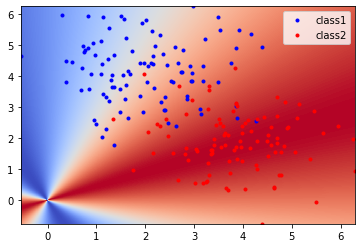

In [12]:
x_r = [min(data[:,0]), max(data[:,0])]
y_r = [min(data[:,1]), max(data[:,1])]
svdd_set_sklearn_backgound(ism, x_r, y_r)
plt.xlim(x_r)
plt.ylim(y_r)
t = np.linspace(start=min(data[:,0]), stop = max(data[:,0]), num=50)
plt.plot(data1[:,0], data1[:,1], 'b.', label="class1")
plt.plot(data2[:,0], data2[:,1], 'r.', label="class2")
plt.legend()
plt.show()
plt.close()

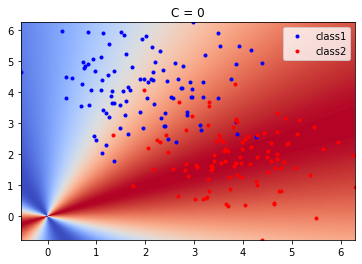

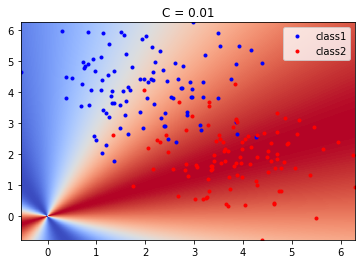

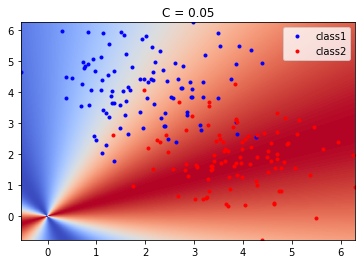

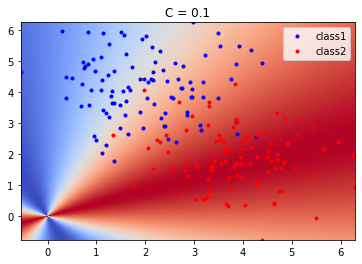

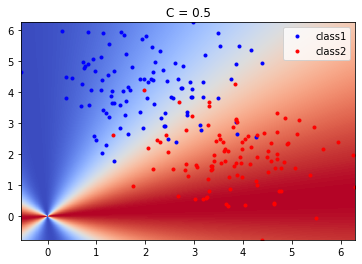

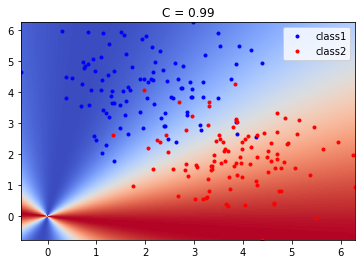

In [14]:
#異常データ5個のみ
for c in [0, 0.01, 0.05, 0.1, 0.5, 0.99]:
    ism = ISM(C=c, eta=0.99, pos=1, kernel=None, gamma='auto')
    ism.fit(data[95:], (-1)*y[95:])
    x_r = [min(data[:,0]), max(data[:,0])]
    y_r = [min(data[:,1]), max(data[:,1])]
    svdd_set_sklearn_backgound(ism, x_r, y_r)
    plt.xlim(x_r)
    plt.ylim(y_r)
    t = np.linspace(start=min(data[:,0]), stop = max(data[:,0]), num=50)
    plt.plot(data1[:,0], data1[:,1], 'b.', label="class1")
    plt.plot(data2[:,0], data2[:,1], 'r.', label="class2")
    plt.title(f'C = {c}')
    plt.legend()
    plt.show()
    plt.close()

## 非線形

In [15]:
#学習
kism = ISM(C=0.5, eta=0.99, pos=None, kernel='rbf', gamma='auto')
kism.fit(data, (-1)*y)

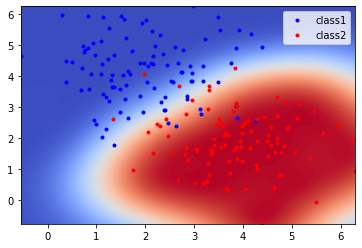

In [16]:
x_r = [min(data[:,0]), max(data[:,0])]
y_r = [min(data[:,1]), max(data[:,1])]
svdd_set_sklearn_backgound(kism, x_r, y_r)
plt.xlim(x_r)
plt.ylim(y_r)
t = np.linspace(start=min(data[:,0]), stop = max(data[:,0]), num=50)
plt.plot(data1[:,0], data1[:,1], 'b.', label="class1")
plt.plot(data2[:,0], data2[:,1], 'r.', label="class2")
plt.legend()
plt.show()
plt.close()

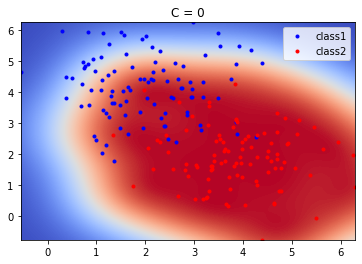

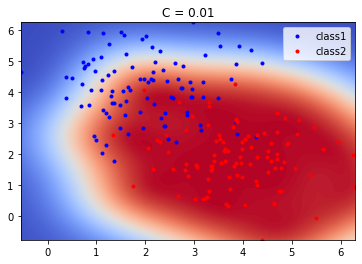

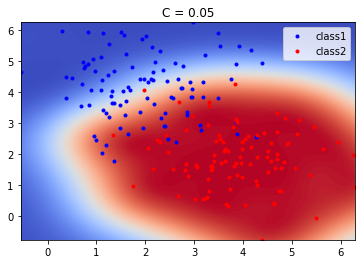

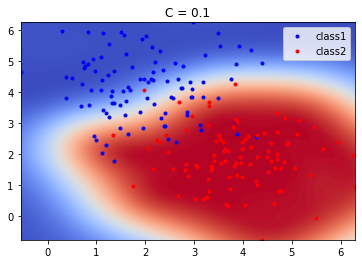

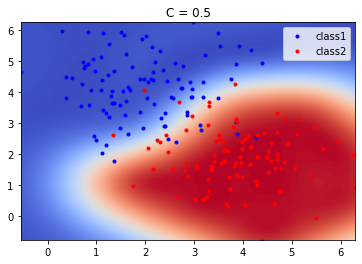

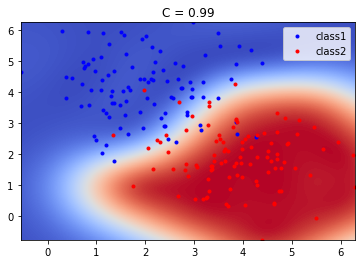

In [17]:
#異常データ5個のみ
for c in [0, 0.01, 0.05, 0.1, 0.5, 0.99]:
    kism = ISM(C=c, eta=0.99, pos=None, kernel='rbf', gamma='auto')
    kism.fit(data[95:], (-1)*y[95:])
    x_r = [min(data[:,0]), max(data[:,0])]
    y_r = [min(data[:,1]), max(data[:,1])]
    svdd_set_sklearn_backgound(kism, x_r, y_r)
    plt.xlim(x_r)
    plt.ylim(y_r)
    t = np.linspace(start=min(data[:,0]), stop = max(data[:,0]), num=50)
    plt.plot(data1[:,0], data1[:,1], 'b.', label="class1")
    plt.plot(data2[:,0], data2[:,1], 'r.', label="class2")
    plt.title(f'C = {c}')
    plt.legend()
    plt.show()
    plt.close()